# Making sense of system logs

Importing all the libraries and methods.

In [1]:
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from replaceall import replaceall
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

Loading clusters data.

In [2]:
with open('result.json') as file:
    data = json.loads(file.read())
clusters = sorted(data['clusters'], key=lambda cluster: cluster['count'], reverse=True)

Preprocessing.

In [3]:
to_remove = ['<timestamp>', '<IP>', '<URL>', '<path>', '<instance_id>', '<number>', '---', '[', ']', '(', ')']
to_replace_with_space = ['.', ',', '=']

patterns = [cluster['pattern'] for cluster in clusters]
patterns_preprocessed = [replaceall(pattern, to_remove, '') for pattern in patterns]
patterns_preprocessed = [replaceall(pattern, to_replace_with_space, ' ') for pattern in patterns_preprocessed]
patterns_preprocessed = [re.sub(r'\s+', ' ', pattern).strip().lower() for pattern in patterns_preprocessed]

Transforming patterns into vectors and calculating cosine similarities between them.

In [4]:
tfidf = TfidfVectorizer().fit_transform(patterns)

In [5]:
cosine_similarities = cosine_similarity(tfidf, tfidf)

Using MDS to get the embedded coordinates. 

In [6]:
cosine_dissimilarities = 1 - cosine_similarities
mds = MDS(n_components=2, dissimilarity='precomputed')
reduced_patterns = mds.fit_transform(cosine_dissimilarities)

Preparing data and visualizing it on a plot.

In [7]:
count = np.array([log['count'] for log in clusters])
count_norm = (count - np.min(count)) / np.max(count)

sizes = count_norm * 2900 + 100
colors = count_norm * 0.75 + 0.25
data = zip(sizes, colors, reduced_patterns)

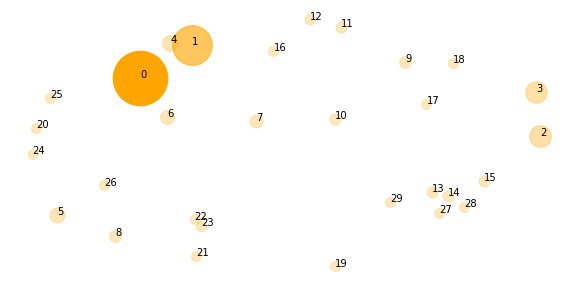

In [8]:
plt.figure(figsize=(10, 5))
plt.axis('off')
for i, (size, color, position) in enumerate(data):
    plt.scatter(position[0], position[1], s=size, alpha=color, c='orange')
    plt.annotate(i, xy=position)
plt.show()